In [1]:
import os
import torch
import time
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch.cuda import amp
from scipy.io import savemat
import torch.nn.functional as F
import tonic
import tonic.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Now import from models
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from models.ReActNet_A_Qaw import *
from models.utils import *

os.environ["CUDA_VISIBLE_DEVICES"] = '5'

/home/lab/plongour/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
Begin_epoch = 0
Max_epoch = 256
Learning_rate = 1e-3
Weight_decay = 5e-6
Momentum = 0.9
Top_k = 5
SENSOR_SIZE = (128, 128, 2)
batch_size = 64

Dataset_path = '../data'
Workers = 8
Targetnum = 11

Test_every_iteration = None
Name_suffix = '_step2_nbEvents'
Savemodel_path = './savemodels_DVS/'
Record_path = './recorddata_DVS/'
if not os.path.exists(Savemodel_path):
    os.mkdir(Savemodel_path)
if not os.path.exists(Record_path):
    os.mkdir(Record_path)

_seed_ = 2023
torch.manual_seed(_seed_)
np.random.seed(_seed_)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [ ]:
def convert_to_event_representation(frame_sequence):
    time_steps, channels, height, width = frame_sequence.shape  # (time_steps, 2, 128, 128)

    # Sum positive and negative events shape: (height, width)
    event_sum = np.sum(frame_sequence[:, 0] + frame_sequence[:, 1], axis=0).astype(np.float32)  # (128, 128)
    event_sum /= np.max(event_sum) if np.max(event_sum) > 0 else event_sum  # Normalize to [0, 1]
    
    return event_sum



# Set paths
output_dir = "./processed_dvsgesture"
train_data_path = os.path.join(output_dir, "train_data"+Name_suffix+".pkl")
test_data_path = os.path.join(output_dir, "test_data"+Name_suffix+".pkl")

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Check if processed data already exists
if os.path.exists(train_data_path) and os.path.exists(test_data_path):
    # Load processed data
    with open(train_data_path, "rb") as f:
        train_images, train_labels = pickle.load(f)
    with open(test_data_path, "rb") as f:
        test_images, test_labels = pickle.load(f)
    print("Loaded preprocessed data from files")
else:
    # Load dataset
    transform = transforms.Compose([
        transforms.Denoise(filter_time=10000),
        transforms.ToFrame(sensor_size=SENSOR_SIZE, time_window=25000)
    ])

    dataset_train = tonic.datasets.DVSGesture(save_to=Dataset_path, train=True, transform=transform)
    dataset_test = tonic.datasets.DVSGesture(save_to=Dataset_path, train=False, transform=transform)

    # Process training data
    train_images = []
    train_labels = []
    for i, (frames, label) in enumerate(dataset_train):
        if i % 100 == 0:
            print(f"Processing training sample {i}/{len(dataset_train)}")
        img = convert_to_event_representation(frames)
        train_images.append(torch.FloatTensor(img))
        train_labels.append(label)
        
    # Process test data
    test_images = []
    test_labels = []
    for i, (frames, label) in enumerate(dataset_test):
        if i % 100 == 0:
            print(f"Processing test sample {i}/{len(dataset_test)}")
        img = convert_to_event_representation(frames)
        test_images.append(torch.FloatTensor(img))
        test_labels.append(label)

    
    # Save processed data
    with open(train_data_path, "wb") as f:
        pickle.dump((train_images, train_labels), f)
    with open(test_data_path, "wb") as f:
        pickle.dump((test_images, test_labels), f)
    print("Saved preprocessed data to files")


# Create dataloaders
train_data_loader = torch.utils.data.DataLoader(
    list(zip(train_images, train_labels)),
    batch_size=batch_size,
    shuffle=True,
    num_workers=Workers,
    pin_memory=True
)

test_data_loader = torch.utils.data.DataLoader(
    list(zip(test_images, test_labels)),
    batch_size=batch_size,
    shuffle=False,
    num_workers=Workers,
    pin_memory=True
)

Loaded preprocessed data from files



Statistiques du canal:

Événements:
  Min: 0.0000
  Max: 1.0000
  Mean: 0.0159
  Std: 0.0842


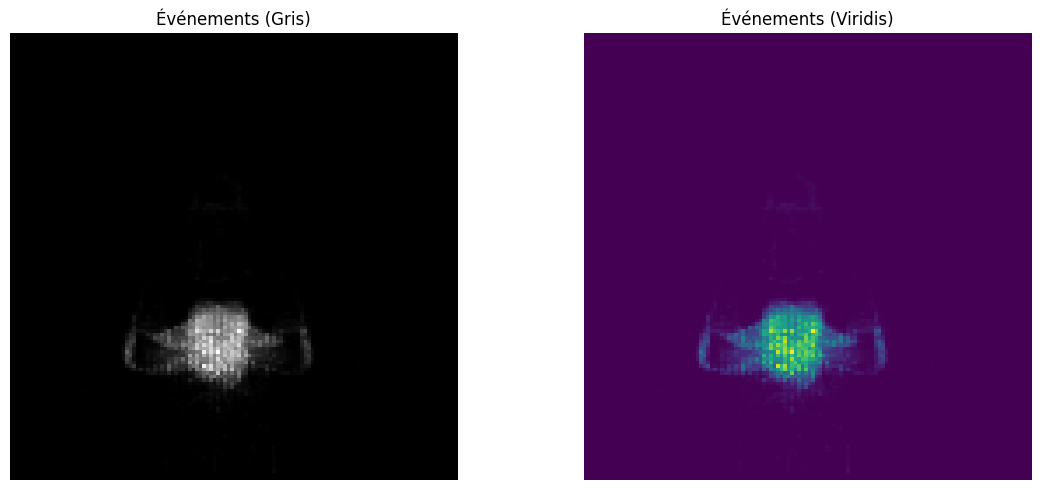

In [4]:
def visualize_event_representation(data_loader, sample_index=0):
    """
    Visualise un seul canal d'événements pour un échantillon du DataLoader,
    avec statistiques.
    
    Args:
        data_loader: PyTorch DataLoader contenant des pairs (images, labels).
        sample_index: Index de l'échantillon à visualiser (défaut: 0).
    """
    # Obtenir un batch du DataLoader
    for batch in data_loader:
        images, labels = batch
        break  # Prendre uniquement le premier batch
    
    # Sélectionner l'échantillon à l'index spécifié
    if sample_index >= images.shape[0]:
        raise ValueError(f"sample_index {sample_index} est hors limites pour un batch de taille {images.shape[0]}")
    
    # Extraire l'image (forme: (1, height, width))
    img = images[sample_index].numpy()  # Convertir le tenseur PyTorch en tableau NumPy
    
    # S'assurer que nous avons un tableau 2D même si la dimension du canal est 1
    if len(img.shape) == 3:
        event_data = img[0]  # Premier (et seul) canal
    else:
        event_data = img  # Déjà en 2D
    
    # Calculer les statistiques
    stats = {
        "Événements": {
            "min": np.min(event_data),
            "max": np.max(event_data),
            "mean": np.mean(event_data),
            "std": np.std(event_data)
        }
    }
    
    # Afficher les statistiques
    print("\nStatistiques du canal:")
    for channel, values in stats.items():
        print(f"\n{channel}:")
        print(f"  Min: {values['min']:.4f}")
        print(f"  Max: {values['max']:.4f}")
        print(f"  Mean: {values['mean']:.4f}")
        print(f"  Std: {values['std']:.4f}")
    
    # Créer une figure pour la visualisation
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot en niveaux de gris
    axes[0].imshow(event_data, cmap='gray')
    axes[0].set_title("Événements (Gris)")
    axes[0].axis('off')
    
    # Plot avec une colormap différente pour plus de contraste
    axes[1].imshow(event_data, cmap='viridis')
    axes[1].set_title("Événements (Viridis)")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_event_representation(train_data_loader, sample_index=0)

In [5]:
net = Reactnet(num_classes=Targetnum, imagenet=False)

# Modifier la première couche pour accepter 1 canal au lieu de 3
net.feature[0] = firstconv3x3(1, stage_out_channel[0], 1)

In [6]:
net = nn.DataParallel(net).cuda()
max_test_acc = 0.

Test_top1 = []
Test_topk = []
Test_lossall = []
Epoch_list = []
Iteration_list = []

In [7]:
all_parameters = net.parameters()
weight_parameters = []
for pname, p in net.named_parameters():
    if (p.ndimension() == 4 or 'conv' in pname) and 'L_alpha' not in pname:
        weight_parameters.append(p)
weight_parameters_id = list(map(id, weight_parameters))
other_parameters = list(filter(lambda p: id(p) not in weight_parameters_id, all_parameters))

criterion_train = DistributionLoss()
criterion_test = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([
    {'params' : other_parameters, 'weight_decay' : 0., 'initial_lr': Learning_rate},
    {'params' : weight_parameters, 'weight_decay' : Weight_decay, 'initial_lr': Learning_rate}],
    lr = Learning_rate)
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step : (1.0-step/Max_epoch), last_epoch=Begin_epoch-1)

In [8]:
def test_model(net, max_test_acc, data_loader=test_data_loader, criterion=criterion_test, epoch=None, iteration=None, record=True):
    net.eval()
    test_samples = 0
    test_loss = 0
    test_acc_top1 = 0
    test_acc_topk = 0
    
    with torch.no_grad():
        for img, label in tqdm(data_loader):
            img = img.unsqueeze(1) 
            img = img.cuda()
            label = label.cuda()
            
            out_fr = net(img)
            loss = criterion(out_fr, label)
                
            test_samples += label.numel()
            test_loss += loss.item() * label.numel()

            test_acc_top1 += (out_fr.argmax(1) == label).float().sum().item()
            _, pred = out_fr.topk(Top_k, 1, True, True)
            test_acc_topk += torch.eq(pred, label.view(-1,1)).float().sum().item()
    
    test_loss /= test_samples
    test_acc_top1 /= test_samples
    test_acc_topk /= test_samples

    if test_acc_top1 >= max_test_acc:
        max_test_acc = test_acc_top1
        torch.save(net.state_dict(), Savemodel_path + f'max_acc{Name_suffix}.h5')
        np.save(Savemodel_path + f'max_acc{Name_suffix}.npy', np.array(max_test_acc))

    if record:
        assert epoch is not None, "epoch is None!"
        assert iteration is not None, "iteration is None!"
        
        Epoch_list.append(epoch+1)
        Iteration_list.append(iteration+1)
        Test_top1.append(test_acc_top1)
        Test_topk.append(test_acc_topk)
        Test_lossall.append(test_loss)

        record_data = np.array([Epoch_list, Iteration_list, Test_top1, Test_topk, Test_lossall]).T
        mdic = {f'Record_data':record_data, f'Record_meaning':['Epoch_list', 'Iteration_list', 'Test_top1', f'Test_top{Top_k}', 'Test_loss']}

        savemat(Record_path + f'Test_{Begin_epoch}_{epoch}{Name_suffix}.mat',mdic)
        if os.path.exists(Record_path + f'Test_{Begin_epoch}_{epoch-1}{Name_suffix}.mat'):
            os.remove(Record_path + f'Test_{Begin_epoch}_{epoch-1}{Name_suffix}.mat')

    return test_loss, test_acc_top1, test_acc_topk, max_test_acc

In [9]:
def train_model(net, max_test_acc, epoch, data_loader=train_data_loader, optimizer=optimizer, criterion=criterion_test, record=True):
    train_samples = 0
    train_loss = 0
    train_acc_top1 = 0
    train_acc_topk = 0
    
    for i, (img, label) in enumerate(tqdm(data_loader)):
        net.train()
        img = img.unsqueeze(1) 
        img = img.cuda()
        label = label.cuda()
        
        out_fr = net(img)
        loss = criterion(out_fr, label)
            
        train_samples += label.numel()
        train_loss += loss.item() * label.numel()

        train_acc_top1 += (out_fr.argmax(1) == label).float().sum().item()
        _, pred = out_fr.topk(Top_k, 1, True, True)
        train_acc_topk += torch.eq(pred, label.view(-1,1)).float().sum().item()
        
        optimizer.zero_grad()
        loss.backward()

        parameters_list = []
        for name, p in net.named_parameters():
            if not 'fc' in name:
                parameters_list.append(p)
        adaptive_clip_grad(parameters_list, clip_factor=0.001)
            
        optimizer.step()

        if Test_every_iteration is not None:
            if (i+1) % Test_every_iteration == 0:
                test_loss, test_acc_top1, test_acc_topk, max_test_acc = test_model(net, max_test_acc, epoch=epoch, iteration=i, record=record)
                print(f'Test_loss: {test_loss:.4f}, Test_acc_top1: {test_acc_top1:.4f}, Test_acc_top{Top_k}: {test_acc_topk:.4f}, Max_test_acc: {max_test_acc:.4f}')
    
    train_loss /= train_samples
    train_acc_top1 /= train_samples
    train_acc_topk /= train_samples

    test_loss, test_acc_top1, test_acc_topk, max_test_acc = test_model(net, max_test_acc, epoch=epoch, iteration=i, record=record)
        
    return train_loss, train_acc_top1, train_acc_topk, test_loss, test_acc_top1, test_acc_topk, max_test_acc

In [10]:
for epoch in range(Begin_epoch, Max_epoch):

    start_time = time.time()
    train_loss, train_acc_top1, train_acc_topk, test_loss, test_acc_top1, test_acc_topk, max_test_acc = train_model(net, max_test_acc, epoch)
    
    for param_group in optimizer.param_groups:
        lr = param_group['lr']
        
    lr_scheduler.step()

    print(f'''epoch={epoch}, train_acc_top1={train_acc_top1:.4f}, train_acc_top{Top_k}={train_acc_topk:.4f}, train_loss={train_loss:.4f}, test_top1={test_acc_top1:.4f}, test_top{Top_k}={test_acc_topk:.4f}, test_loss={test_loss:.4f}, max_test_acc={max_test_acc:.4f}, total_time={(time.time() - start_time):.4f}, LR={lr:.8f}''')
    
    torch.save(net.state_dict(), Savemodel_path + f'epoch{epoch}{Name_suffix}.h5')
    if os.path.exists(Savemodel_path + f'epoch{epoch-1}{Name_suffix}.h5'):
        os.remove(Savemodel_path + f'epoch{epoch-1}{Name_suffix}.h5')

100%|██████████| 5/5 [00:00<00:00,  6.87it/s]


epoch=0, train_acc_top1=0.0929, train_acc_top5=0.4912, train_loss=15.8008, test_top1=0.1061, test_top5=0.4848, test_loss=13.0278, max_test_acc=0.1061, total_time=6.7962, LR=0.00100000


100%|██████████| 5/5 [00:00<00:00,  6.98it/s]


epoch=1, train_acc_top1=0.0994, train_acc_top5=0.4958, train_loss=8.7717, test_top1=0.2083, test_top5=0.6212, test_loss=4.3060, max_test_acc=0.2083, total_time=7.2231, LR=0.00099609


100%|██████████| 5/5 [00:00<00:00,  6.80it/s]


epoch=2, train_acc_top1=0.1337, train_acc_top5=0.5682, train_loss=6.1409, test_top1=0.0909, test_top5=0.4545, test_loss=8.0172, max_test_acc=0.2083, total_time=6.0686, LR=0.00099219


100%|██████████| 5/5 [00:00<00:00,  7.06it/s]


epoch=3, train_acc_top1=0.1086, train_acc_top5=0.5079, train_loss=5.7384, test_top1=0.0985, test_top5=0.4545, test_loss=4.5894, max_test_acc=0.2083, total_time=5.9880, LR=0.00098828


100%|██████████| 5/5 [00:00<00:00,  7.06it/s]


epoch=4, train_acc_top1=0.0929, train_acc_top5=0.4717, train_loss=4.6578, test_top1=0.0909, test_top5=0.4167, test_loss=4.0119, max_test_acc=0.2083, total_time=5.9761, LR=0.00098438


100%|██████████| 5/5 [00:00<00:00,  7.09it/s]


epoch=5, train_acc_top1=0.0901, train_acc_top5=0.4448, train_loss=4.4263, test_top1=0.0720, test_top5=0.4545, test_loss=3.8866, max_test_acc=0.2083, total_time=5.9574, LR=0.00098047


100%|██████████| 5/5 [00:00<00:00,  6.40it/s]


epoch=6, train_acc_top1=0.1058, train_acc_top5=0.5014, train_loss=3.9511, test_top1=0.0985, test_top5=0.4583, test_loss=4.2729, max_test_acc=0.2083, total_time=6.0538, LR=0.00097656


100%|██████████| 5/5 [00:00<00:00,  6.54it/s]


epoch=7, train_acc_top1=0.1077, train_acc_top5=0.5534, train_loss=3.0164, test_top1=0.1780, test_top5=0.6970, test_loss=2.6854, max_test_acc=0.2083, total_time=6.0199, LR=0.00097266


100%|██████████| 5/5 [00:00<00:00,  6.47it/s]


epoch=8, train_acc_top1=0.1746, train_acc_top5=0.6648, train_loss=2.7876, test_top1=0.1932, test_top5=0.7311, test_loss=2.3161, max_test_acc=0.2083, total_time=6.0147, LR=0.00096875


100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


epoch=9, train_acc_top1=0.1096, train_acc_top5=0.5738, train_loss=3.6653, test_top1=0.1705, test_top5=0.5530, test_loss=2.9951, max_test_acc=0.2083, total_time=6.0426, LR=0.00096484


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=10, train_acc_top1=0.1439, train_acc_top5=0.6286, train_loss=2.6463, test_top1=0.2311, test_top5=0.7311, test_loss=2.5404, max_test_acc=0.2311, total_time=6.3240, LR=0.00096094


100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


epoch=11, train_acc_top1=0.1764, train_acc_top5=0.7400, train_loss=2.4686, test_top1=0.1780, test_top5=0.6856, test_loss=2.9293, max_test_acc=0.2311, total_time=5.9851, LR=0.00095703


100%|██████████| 5/5 [00:00<00:00,  7.01it/s]


epoch=12, train_acc_top1=0.2098, train_acc_top5=0.7335, train_loss=2.4189, test_top1=0.1856, test_top5=0.7765, test_loss=2.8433, max_test_acc=0.2311, total_time=6.0418, LR=0.00095312


100%|██████████| 5/5 [00:00<00:00,  7.35it/s]


epoch=13, train_acc_top1=0.1551, train_acc_top5=0.6342, train_loss=3.8294, test_top1=0.1932, test_top5=0.6402, test_loss=2.6196, max_test_acc=0.2311, total_time=5.8876, LR=0.00094922


100%|██████████| 5/5 [00:00<00:00,  6.93it/s]


epoch=14, train_acc_top1=0.1811, train_acc_top5=0.7103, train_loss=2.4252, test_top1=0.1667, test_top5=0.7273, test_loss=2.7745, max_test_acc=0.2311, total_time=5.9782, LR=0.00094531


100%|██████████| 5/5 [00:00<00:00,  7.32it/s]


epoch=15, train_acc_top1=0.1718, train_acc_top5=0.6620, train_loss=3.0587, test_top1=0.1856, test_top5=0.5909, test_loss=2.3250, max_test_acc=0.2311, total_time=5.9111, LR=0.00094141


100%|██████████| 5/5 [00:00<00:00,  7.21it/s]


epoch=16, train_acc_top1=0.2266, train_acc_top5=0.7577, train_loss=2.0947, test_top1=0.2500, test_top5=0.7159, test_loss=2.1611, max_test_acc=0.2500, total_time=6.2096, LR=0.00093750


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


epoch=17, train_acc_top1=0.2711, train_acc_top5=0.7837, train_loss=2.2037, test_top1=0.2689, test_top5=0.8902, test_loss=1.7345, max_test_acc=0.2689, total_time=6.2333, LR=0.00093359


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


epoch=18, train_acc_top1=0.2256, train_acc_top5=0.7159, train_loss=2.6269, test_top1=0.3447, test_top5=0.7576, test_loss=1.8197, max_test_acc=0.3447, total_time=6.2102, LR=0.00092969


100%|██████████| 5/5 [00:00<00:00,  7.19it/s]


epoch=19, train_acc_top1=0.3278, train_acc_top5=0.8422, train_loss=1.7731, test_top1=0.4015, test_top5=0.8939, test_loss=1.5745, max_test_acc=0.4015, total_time=7.4663, LR=0.00092578


100%|██████████| 5/5 [00:00<00:00,  7.32it/s]


epoch=20, train_acc_top1=0.4067, train_acc_top5=0.9155, train_loss=1.5649, test_top1=0.2576, test_top5=0.8030, test_loss=2.0534, max_test_acc=0.4015, total_time=5.9072, LR=0.00092188


100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


epoch=21, train_acc_top1=0.3788, train_acc_top5=0.8988, train_loss=1.8133, test_top1=0.5303, test_top5=0.9470, test_loss=1.3358, max_test_acc=0.5303, total_time=6.2663, LR=0.00091797


100%|██████████| 5/5 [00:00<00:00,  7.27it/s]


epoch=22, train_acc_top1=0.3500, train_acc_top5=0.8654, train_loss=2.2121, test_top1=0.4621, test_top5=0.8864, test_loss=1.4673, max_test_acc=0.5303, total_time=5.9157, LR=0.00091406


100%|██████████| 5/5 [00:00<00:00,  7.16it/s]


epoch=23, train_acc_top1=0.3361, train_acc_top5=0.8347, train_loss=1.9884, test_top1=0.5341, test_top5=0.9735, test_loss=1.4078, max_test_acc=0.5341, total_time=6.2547, LR=0.00091016


100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


epoch=24, train_acc_top1=0.4290, train_acc_top5=0.8904, train_loss=1.5332, test_top1=0.4924, test_top5=0.9886, test_loss=1.2150, max_test_acc=0.5341, total_time=5.9063, LR=0.00090625


100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


epoch=25, train_acc_top1=0.5200, train_acc_top5=0.9610, train_loss=1.2354, test_top1=0.5909, test_top5=0.9848, test_loss=1.0072, max_test_acc=0.5909, total_time=6.3233, LR=0.00090234


100%|██████████| 5/5 [00:00<00:00,  7.19it/s]


epoch=26, train_acc_top1=0.4726, train_acc_top5=0.9424, train_loss=1.3876, test_top1=0.4167, test_top5=0.9773, test_loss=1.2789, max_test_acc=0.5909, total_time=5.9319, LR=0.00089844


100%|██████████| 5/5 [00:00<00:00,  7.23it/s]


epoch=27, train_acc_top1=0.5227, train_acc_top5=0.9749, train_loss=1.1393, test_top1=0.4886, test_top5=0.9394, test_loss=1.4740, max_test_acc=0.5909, total_time=5.9202, LR=0.00089453


100%|██████████| 5/5 [00:00<00:00,  7.25it/s]


epoch=28, train_acc_top1=0.5859, train_acc_top5=0.9786, train_loss=1.0431, test_top1=0.5985, test_top5=1.0000, test_loss=0.9303, max_test_acc=0.5985, total_time=6.2353, LR=0.00089063


100%|██████████| 5/5 [00:00<00:00,  7.16it/s]


epoch=29, train_acc_top1=0.5682, train_acc_top5=0.9833, train_loss=0.9874, test_top1=0.5909, test_top5=1.0000, test_loss=0.9296, max_test_acc=0.5985, total_time=5.9401, LR=0.00088672


100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


epoch=30, train_acc_top1=0.6305, train_acc_top5=0.9851, train_loss=0.8649, test_top1=0.6477, test_top5=0.9886, test_loss=0.7867, max_test_acc=0.6477, total_time=6.4455, LR=0.00088281


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=31, train_acc_top1=0.6119, train_acc_top5=0.9814, train_loss=0.9550, test_top1=0.6970, test_top5=0.9962, test_loss=0.7533, max_test_acc=0.6970, total_time=7.0343, LR=0.00087891


100%|██████████| 5/5 [00:00<00:00,  7.32it/s]


epoch=32, train_acc_top1=0.6806, train_acc_top5=0.9944, train_loss=0.7765, test_top1=0.6742, test_top5=1.0000, test_loss=0.7432, max_test_acc=0.6970, total_time=5.9295, LR=0.00087500


100%|██████████| 5/5 [00:00<00:00,  7.33it/s]


epoch=33, train_acc_top1=0.6630, train_acc_top5=0.9814, train_loss=0.8118, test_top1=0.6705, test_top5=1.0000, test_loss=0.6767, max_test_acc=0.6970, total_time=5.9095, LR=0.00087109


100%|██████████| 5/5 [00:00<00:00,  7.06it/s]


epoch=34, train_acc_top1=0.6295, train_acc_top5=0.9870, train_loss=0.8875, test_top1=0.6856, test_top5=1.0000, test_loss=0.7174, max_test_acc=0.6970, total_time=5.9471, LR=0.00086719


100%|██████████| 5/5 [00:00<00:00,  7.15it/s]


epoch=35, train_acc_top1=0.6565, train_acc_top5=0.9898, train_loss=0.8932, test_top1=0.6098, test_top5=0.9545, test_loss=1.0854, max_test_acc=0.6970, total_time=5.9250, LR=0.00086328


100%|██████████| 5/5 [00:00<00:00,  7.20it/s]


epoch=36, train_acc_top1=0.6351, train_acc_top5=0.9889, train_loss=0.8815, test_top1=0.6515, test_top5=0.9962, test_loss=0.8535, max_test_acc=0.6970, total_time=5.9472, LR=0.00085938


100%|██████████| 5/5 [00:00<00:00,  5.88it/s]


epoch=37, train_acc_top1=0.6927, train_acc_top5=0.9879, train_loss=0.7287, test_top1=0.6212, test_top5=0.9811, test_loss=1.0216, max_test_acc=0.6970, total_time=6.0811, LR=0.00085547


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=38, train_acc_top1=0.6852, train_acc_top5=0.9907, train_loss=0.7132, test_top1=0.6515, test_top5=0.9735, test_loss=0.9334, max_test_acc=0.6970, total_time=5.9439, LR=0.00085156


100%|██████████| 5/5 [00:00<00:00,  7.24it/s]


epoch=39, train_acc_top1=0.6899, train_acc_top5=0.9935, train_loss=0.7072, test_top1=0.6932, test_top5=1.0000, test_loss=0.7071, max_test_acc=0.6970, total_time=5.9269, LR=0.00084766


100%|██████████| 5/5 [00:00<00:00,  7.01it/s]


epoch=40, train_acc_top1=0.7038, train_acc_top5=0.9991, train_loss=0.6640, test_top1=0.6742, test_top5=0.9924, test_loss=0.7820, max_test_acc=0.6970, total_time=5.9427, LR=0.00084375


100%|██████████| 5/5 [00:00<00:00,  7.05it/s]


epoch=41, train_acc_top1=0.6695, train_acc_top5=0.9833, train_loss=0.8528, test_top1=0.5758, test_top5=0.9356, test_loss=1.4841, max_test_acc=0.6970, total_time=5.9381, LR=0.00083984


100%|██████████| 5/5 [00:00<00:00,  6.92it/s]


epoch=42, train_acc_top1=0.6639, train_acc_top5=0.9851, train_loss=0.8443, test_top1=0.6667, test_top5=0.9886, test_loss=0.7699, max_test_acc=0.6970, total_time=5.9605, LR=0.00083594


100%|██████████| 5/5 [00:00<00:00,  7.27it/s]


epoch=43, train_acc_top1=0.7149, train_acc_top5=0.9954, train_loss=0.6556, test_top1=0.6364, test_top5=0.9962, test_loss=0.7845, max_test_acc=0.6970, total_time=5.9047, LR=0.00083203


100%|██████████| 5/5 [00:00<00:00,  7.20it/s]


epoch=44, train_acc_top1=0.7261, train_acc_top5=0.9981, train_loss=0.5977, test_top1=0.7121, test_top5=0.9962, test_loss=0.6555, max_test_acc=0.7121, total_time=6.2841, LR=0.00082812


100%|██████████| 5/5 [00:00<00:00,  7.21it/s]


epoch=45, train_acc_top1=0.7354, train_acc_top5=0.9963, train_loss=0.5588, test_top1=0.7348, test_top5=0.9962, test_loss=0.5821, max_test_acc=0.7348, total_time=6.2299, LR=0.00082422


100%|██████████| 5/5 [00:00<00:00,  6.62it/s]


epoch=46, train_acc_top1=0.7307, train_acc_top5=0.9926, train_loss=0.6351, test_top1=0.7008, test_top5=0.9962, test_loss=0.6015, max_test_acc=0.7348, total_time=5.9806, LR=0.00082031


100%|██████████| 5/5 [00:00<00:00,  7.01it/s]


epoch=47, train_acc_top1=0.7512, train_acc_top5=0.9972, train_loss=0.5620, test_top1=0.7121, test_top5=0.9848, test_loss=0.7197, max_test_acc=0.7348, total_time=6.0170, LR=0.00081641


100%|██████████| 5/5 [00:00<00:00,  7.28it/s]


epoch=48, train_acc_top1=0.7001, train_acc_top5=0.9851, train_loss=0.8166, test_top1=0.7500, test_top5=1.0000, test_loss=0.6009, max_test_acc=0.7500, total_time=6.2857, LR=0.00081250


100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


epoch=49, train_acc_top1=0.7604, train_acc_top5=0.9981, train_loss=0.5263, test_top1=0.6970, test_top5=1.0000, test_loss=0.7467, max_test_acc=0.7500, total_time=6.0022, LR=0.00080859


100%|██████████| 5/5 [00:00<00:00,  7.16it/s]


epoch=50, train_acc_top1=0.5766, train_acc_top5=0.9406, train_loss=1.5093, test_top1=0.6818, test_top5=1.0000, test_loss=0.6759, max_test_acc=0.7500, total_time=5.9053, LR=0.00080469


100%|██████████| 5/5 [00:00<00:00,  7.04it/s]


epoch=51, train_acc_top1=0.7493, train_acc_top5=0.9935, train_loss=0.5889, test_top1=0.6856, test_top5=0.9886, test_loss=0.7125, max_test_acc=0.7500, total_time=5.9795, LR=0.00080078


100%|██████████| 5/5 [00:00<00:00,  7.02it/s]


epoch=52, train_acc_top1=0.7790, train_acc_top5=0.9972, train_loss=0.4730, test_top1=0.7197, test_top5=1.0000, test_loss=0.6085, max_test_acc=0.7500, total_time=5.9433, LR=0.00079688


100%|██████████| 5/5 [00:00<00:00,  7.30it/s]


epoch=53, train_acc_top1=0.6462, train_acc_top5=0.9294, train_loss=1.8471, test_top1=0.6364, test_top5=0.9735, test_loss=0.9975, max_test_acc=0.7500, total_time=5.8919, LR=0.00079297


100%|██████████| 5/5 [00:00<00:00,  7.19it/s]


epoch=54, train_acc_top1=0.3825, train_acc_top5=0.7465, train_loss=5.4170, test_top1=0.4735, test_top5=0.8902, test_loss=1.6209, max_test_acc=0.7500, total_time=5.9066, LR=0.00078906


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=55, train_acc_top1=0.5274, train_acc_top5=0.9452, train_loss=1.1999, test_top1=0.2879, test_top5=0.9773, test_loss=1.9096, max_test_acc=0.7500, total_time=5.9330, LR=0.00078516


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=56, train_acc_top1=0.3463, train_acc_top5=0.7725, train_loss=2.7532, test_top1=0.6250, test_top5=0.9697, test_loss=0.9966, max_test_acc=0.7500, total_time=5.9498, LR=0.00078125


100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


epoch=57, train_acc_top1=0.6518, train_acc_top5=0.9833, train_loss=0.8820, test_top1=0.6515, test_top5=0.9886, test_loss=0.8036, max_test_acc=0.7500, total_time=5.9102, LR=0.00077734


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=58, train_acc_top1=0.6639, train_acc_top5=0.9898, train_loss=0.8437, test_top1=0.7159, test_top5=0.9962, test_loss=0.6656, max_test_acc=0.7500, total_time=5.9236, LR=0.00077344


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=59, train_acc_top1=0.6787, train_acc_top5=0.9851, train_loss=0.8043, test_top1=0.6742, test_top5=0.9697, test_loss=0.9056, max_test_acc=0.7500, total_time=5.9254, LR=0.00076953


100%|██████████| 5/5 [00:00<00:00,  7.26it/s]


epoch=60, train_acc_top1=0.7456, train_acc_top5=0.9981, train_loss=0.5951, test_top1=0.7235, test_top5=1.0000, test_loss=0.5794, max_test_acc=0.7500, total_time=5.9108, LR=0.00076563


100%|██████████| 5/5 [00:01<00:00,  3.54it/s]


epoch=61, train_acc_top1=0.6778, train_acc_top5=0.9629, train_loss=0.9115, test_top1=0.5114, test_top5=0.9697, test_loss=1.2773, max_test_acc=0.7500, total_time=6.6441, LR=0.00076172


100%|██████████| 5/5 [00:00<00:00,  7.23it/s]


epoch=62, train_acc_top1=0.6955, train_acc_top5=0.9879, train_loss=0.7448, test_top1=0.7235, test_top5=1.0000, test_loss=0.5874, max_test_acc=0.7500, total_time=5.9126, LR=0.00075781


100%|██████████| 5/5 [00:00<00:00,  7.07it/s]


epoch=63, train_acc_top1=0.7874, train_acc_top5=0.9991, train_loss=0.4485, test_top1=0.7273, test_top5=0.9962, test_loss=0.5793, max_test_acc=0.7500, total_time=5.9345, LR=0.00075391


100%|██████████| 5/5 [00:00<00:00,  7.25it/s]


epoch=64, train_acc_top1=0.7911, train_acc_top5=0.9981, train_loss=0.4520, test_top1=0.7008, test_top5=0.9962, test_loss=0.6388, max_test_acc=0.7500, total_time=5.9133, LR=0.00075000


100%|██████████| 5/5 [00:00<00:00,  5.76it/s]


epoch=65, train_acc_top1=0.7688, train_acc_top5=0.9916, train_loss=0.5682, test_top1=0.1326, test_top5=0.6402, test_loss=7.7744, max_test_acc=0.7500, total_time=6.0985, LR=0.00074609


100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


epoch=66, train_acc_top1=0.4336, train_acc_top5=0.8254, train_loss=2.9348, test_top1=0.6970, test_top5=0.9924, test_loss=0.7560, max_test_acc=0.7500, total_time=5.9168, LR=0.00074219


100%|██████████| 5/5 [00:00<00:00,  7.14it/s]


epoch=67, train_acc_top1=0.7335, train_acc_top5=0.9972, train_loss=0.6262, test_top1=0.7348, test_top5=1.0000, test_loss=0.6458, max_test_acc=0.7500, total_time=5.9154, LR=0.00073828


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=68, train_acc_top1=0.6955, train_acc_top5=0.9480, train_loss=2.2883, test_top1=0.6894, test_top5=0.9848, test_loss=0.7970, max_test_acc=0.7500, total_time=6.7644, LR=0.00073438


100%|██████████| 5/5 [00:00<00:00,  7.29it/s]


epoch=69, train_acc_top1=0.7279, train_acc_top5=0.9916, train_loss=0.6332, test_top1=0.6515, test_top5=0.9773, test_loss=0.8589, max_test_acc=0.7500, total_time=5.8915, LR=0.00073047


100%|██████████| 5/5 [00:00<00:00,  7.23it/s]


epoch=70, train_acc_top1=0.6007, train_acc_top5=0.9155, train_loss=2.1980, test_top1=0.2424, test_top5=0.7348, test_loss=4.5973, max_test_acc=0.7500, total_time=5.9095, LR=0.00072656


100%|██████████| 5/5 [00:00<00:00,  7.20it/s]


epoch=71, train_acc_top1=0.4615, train_acc_top5=0.8644, train_loss=1.9150, test_top1=0.6856, test_top5=0.9545, test_loss=0.9253, max_test_acc=0.7500, total_time=5.9329, LR=0.00072266


100%|██████████| 5/5 [00:00<00:00,  7.32it/s]


epoch=72, train_acc_top1=0.7168, train_acc_top5=0.9861, train_loss=0.6580, test_top1=0.6894, test_top5=0.9924, test_loss=0.6624, max_test_acc=0.7500, total_time=5.8944, LR=0.00071875


100%|██████████| 5/5 [00:00<00:00,  7.19it/s]


epoch=73, train_acc_top1=0.8022, train_acc_top5=0.9991, train_loss=0.4358, test_top1=0.7235, test_top5=1.0000, test_loss=0.6043, max_test_acc=0.7500, total_time=5.9058, LR=0.00071484


100%|██████████| 5/5 [00:00<00:00,  7.26it/s]


epoch=74, train_acc_top1=0.8013, train_acc_top5=1.0000, train_loss=0.3919, test_top1=0.7311, test_top5=1.0000, test_loss=0.5664, max_test_acc=0.7500, total_time=6.5241, LR=0.00071094


100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


epoch=75, train_acc_top1=0.6546, train_acc_top5=0.9499, train_loss=1.4576, test_top1=0.2348, test_top5=0.7424, test_loss=3.4985, max_test_acc=0.7500, total_time=5.9558, LR=0.00070703


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=76, train_acc_top1=0.2851, train_acc_top5=0.7363, train_loss=3.1805, test_top1=0.4848, test_top5=0.9659, test_loss=1.3027, max_test_acc=0.7500, total_time=5.9096, LR=0.00070312


100%|██████████| 5/5 [00:00<00:00,  7.00it/s]


epoch=77, train_acc_top1=0.6230, train_acc_top5=0.9694, train_loss=0.9869, test_top1=0.7121, test_top5=0.9962, test_loss=0.6786, max_test_acc=0.7500, total_time=5.9567, LR=0.00069922


100%|██████████| 5/5 [00:00<00:00,  7.31it/s]


epoch=78, train_acc_top1=0.7168, train_acc_top5=0.9963, train_loss=0.6547, test_top1=0.6856, test_top5=0.9924, test_loss=0.8048, max_test_acc=0.7500, total_time=5.8858, LR=0.00069531


100%|██████████| 5/5 [00:00<00:00,  6.34it/s]


epoch=79, train_acc_top1=0.7307, train_acc_top5=0.9898, train_loss=0.7040, test_top1=0.5985, test_top5=0.9924, test_loss=1.0217, max_test_acc=0.7500, total_time=6.0185, LR=0.00069141


100%|██████████| 5/5 [00:00<00:00,  7.21it/s]


epoch=80, train_acc_top1=0.6732, train_acc_top5=0.9786, train_loss=1.0438, test_top1=0.0909, test_top5=0.5152, test_loss=9.5708, max_test_acc=0.7500, total_time=5.9059, LR=0.00068750


100%|██████████| 5/5 [00:00<00:00,  7.24it/s]


epoch=81, train_acc_top1=0.4968, train_acc_top5=0.8189, train_loss=2.2909, test_top1=0.6932, test_top5=1.0000, test_loss=0.8249, max_test_acc=0.7500, total_time=5.8962, LR=0.00068359


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


epoch=82, train_acc_top1=0.7558, train_acc_top5=0.9963, train_loss=0.5874, test_top1=0.6970, test_top5=0.9848, test_loss=0.7123, max_test_acc=0.7500, total_time=5.9250, LR=0.00067969


100%|██████████| 5/5 [00:00<00:00,  7.31it/s]


epoch=83, train_acc_top1=0.7307, train_acc_top5=0.9944, train_loss=0.6115, test_top1=0.7159, test_top5=0.9886, test_loss=0.7284, max_test_acc=0.7500, total_time=5.8796, LR=0.00067578


100%|██████████| 5/5 [00:00<00:00,  7.20it/s]


epoch=84, train_acc_top1=0.7827, train_acc_top5=0.9991, train_loss=0.4667, test_top1=0.7045, test_top5=0.9886, test_loss=0.6659, max_test_acc=0.7500, total_time=5.9104, LR=0.00067188


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=85, train_acc_top1=0.8236, train_acc_top5=0.9991, train_loss=0.3759, test_top1=0.7008, test_top5=0.9848, test_loss=0.7340, max_test_acc=0.7500, total_time=5.9061, LR=0.00066797


100%|██████████| 5/5 [00:00<00:00,  7.05it/s]


epoch=86, train_acc_top1=0.7762, train_acc_top5=0.9981, train_loss=0.5219, test_top1=0.6705, test_top5=0.9848, test_loss=0.8164, max_test_acc=0.7500, total_time=5.9783, LR=0.00066406


100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


epoch=87, train_acc_top1=0.7948, train_acc_top5=1.0000, train_loss=0.4455, test_top1=0.6591, test_top5=1.0000, test_loss=0.7400, max_test_acc=0.7500, total_time=5.9363, LR=0.00066016


100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


epoch=88, train_acc_top1=0.7957, train_acc_top5=0.9981, train_loss=0.4484, test_top1=0.7424, test_top5=1.0000, test_loss=0.5821, max_test_acc=0.7500, total_time=5.9231, LR=0.00065625


100%|██████████| 5/5 [00:00<00:00,  7.23it/s]


epoch=89, train_acc_top1=0.8115, train_acc_top5=0.9991, train_loss=0.4220, test_top1=0.7008, test_top5=0.9962, test_loss=0.7502, max_test_acc=0.7500, total_time=5.9105, LR=0.00065234


100%|██████████| 5/5 [00:00<00:00,  7.05it/s]


epoch=90, train_acc_top1=0.7066, train_acc_top5=0.9777, train_loss=0.7806, test_top1=0.6553, test_top5=0.9886, test_loss=0.8540, max_test_acc=0.7500, total_time=5.9304, LR=0.00064844


100%|██████████| 5/5 [00:00<00:00,  7.15it/s]


epoch=91, train_acc_top1=0.8310, train_acc_top5=1.0000, train_loss=0.3679, test_top1=0.7462, test_top5=0.9886, test_loss=0.6356, max_test_acc=0.7500, total_time=5.9127, LR=0.00064453


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


epoch=92, train_acc_top1=0.8579, train_acc_top5=1.0000, train_loss=0.2954, test_top1=0.7386, test_top5=0.9962, test_loss=0.5870, max_test_acc=0.7500, total_time=5.9015, LR=0.00064063


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=93, train_acc_top1=0.7929, train_acc_top5=0.9805, train_loss=0.5153, test_top1=0.4356, test_top5=0.9015, test_loss=1.5054, max_test_acc=0.7500, total_time=5.9027, LR=0.00063672


100%|██████████| 5/5 [00:00<00:00,  7.30it/s]


epoch=94, train_acc_top1=0.6072, train_acc_top5=0.9508, train_loss=1.1705, test_top1=0.5568, test_top5=0.9583, test_loss=1.2264, max_test_acc=0.7500, total_time=5.9022, LR=0.00063281


100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


epoch=95, train_acc_top1=0.7456, train_acc_top5=0.9954, train_loss=0.6057, test_top1=0.7159, test_top5=0.9962, test_loss=0.6374, max_test_acc=0.7500, total_time=5.9383, LR=0.00062891


100%|██████████| 5/5 [00:00<00:00,  7.25it/s]


epoch=96, train_acc_top1=0.8189, train_acc_top5=1.0000, train_loss=0.3474, test_top1=0.7424, test_top5=1.0000, test_loss=0.5624, max_test_acc=0.7500, total_time=5.8985, LR=0.00062500


100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


epoch=97, train_acc_top1=0.8672, train_acc_top5=1.0000, train_loss=0.2889, test_top1=0.7311, test_top5=0.9962, test_loss=0.5792, max_test_acc=0.7500, total_time=6.0601, LR=0.00062109


100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


epoch=98, train_acc_top1=0.8570, train_acc_top5=0.9991, train_loss=0.3291, test_top1=0.7311, test_top5=0.9924, test_loss=0.6138, max_test_acc=0.7500, total_time=5.9264, LR=0.00061719


100%|██████████| 5/5 [00:00<00:00,  7.11it/s]


epoch=99, train_acc_top1=0.8858, train_acc_top5=1.0000, train_loss=0.2632, test_top1=0.7652, test_top5=1.0000, test_loss=0.5137, max_test_acc=0.7652, total_time=6.3512, LR=0.00061328


100%|██████████| 5/5 [00:00<00:00,  7.14it/s]


epoch=100, train_acc_top1=0.8635, train_acc_top5=1.0000, train_loss=0.2631, test_top1=0.7879, test_top5=0.9924, test_loss=0.6323, max_test_acc=0.7879, total_time=6.2134, LR=0.00060937


100%|██████████| 5/5 [00:00<00:00,  6.26it/s]


epoch=101, train_acc_top1=0.8366, train_acc_top5=0.9991, train_loss=0.4453, test_top1=0.7311, test_top5=0.9848, test_loss=0.7214, max_test_acc=0.7879, total_time=6.0725, LR=0.00060547


100%|██████████| 5/5 [00:00<00:00,  7.09it/s]


epoch=102, train_acc_top1=0.8570, train_acc_top5=1.0000, train_loss=0.2971, test_top1=0.7727, test_top5=0.9962, test_loss=0.5397, max_test_acc=0.7879, total_time=6.0146, LR=0.00060156


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=103, train_acc_top1=0.8812, train_acc_top5=1.0000, train_loss=0.2532, test_top1=0.7727, test_top5=0.9962, test_loss=0.5490, max_test_acc=0.7879, total_time=5.9538, LR=0.00059766


100%|██████████| 5/5 [00:00<00:00,  7.01it/s]


epoch=104, train_acc_top1=0.8217, train_acc_top5=0.9954, train_loss=0.4574, test_top1=0.7311, test_top5=0.9886, test_loss=0.6841, max_test_acc=0.7879, total_time=5.9743, LR=0.00059375


100%|██████████| 5/5 [00:00<00:00,  6.85it/s]


epoch=105, train_acc_top1=0.8412, train_acc_top5=1.0000, train_loss=0.3340, test_top1=0.7462, test_top5=0.9924, test_loss=0.5595, max_test_acc=0.7879, total_time=5.9435, LR=0.00058984


100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


epoch=106, train_acc_top1=0.9183, train_acc_top5=1.0000, train_loss=0.2177, test_top1=0.7917, test_top5=0.9962, test_loss=0.5081, max_test_acc=0.7917, total_time=6.2441, LR=0.00058594


100%|██████████| 5/5 [00:00<00:00,  7.02it/s]


epoch=107, train_acc_top1=0.9359, train_acc_top5=1.0000, train_loss=0.1864, test_top1=0.7652, test_top5=0.9962, test_loss=0.6217, max_test_acc=0.7917, total_time=5.9650, LR=0.00058203


100%|██████████| 5/5 [00:00<00:00,  6.37it/s]


epoch=108, train_acc_top1=0.9499, train_acc_top5=1.0000, train_loss=0.1525, test_top1=0.7841, test_top5=1.0000, test_loss=0.5560, max_test_acc=0.7917, total_time=6.0553, LR=0.00057812


100%|██████████| 5/5 [00:00<00:00,  6.88it/s]


epoch=109, train_acc_top1=0.9099, train_acc_top5=1.0000, train_loss=0.2317, test_top1=0.7803, test_top5=0.9924, test_loss=0.6318, max_test_acc=0.7917, total_time=6.0650, LR=0.00057422


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=110, train_acc_top1=0.9434, train_acc_top5=1.0000, train_loss=0.1617, test_top1=0.7386, test_top5=0.9962, test_loss=0.7227, max_test_acc=0.7917, total_time=5.9945, LR=0.00057031


100%|██████████| 5/5 [00:00<00:00,  7.04it/s]


epoch=111, train_acc_top1=0.9554, train_acc_top5=1.0000, train_loss=0.1454, test_top1=0.7614, test_top5=0.9924, test_loss=0.6939, max_test_acc=0.7917, total_time=5.9986, LR=0.00056641


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=112, train_acc_top1=0.9499, train_acc_top5=1.0000, train_loss=0.1376, test_top1=0.7424, test_top5=0.9848, test_loss=0.7823, max_test_acc=0.7917, total_time=5.9292, LR=0.00056250


100%|██████████| 5/5 [00:00<00:00,  6.76it/s]


epoch=113, train_acc_top1=0.9777, train_acc_top5=1.0000, train_loss=0.0877, test_top1=0.7652, test_top5=0.9848, test_loss=0.7298, max_test_acc=0.7917, total_time=5.9909, LR=0.00055859


100%|██████████| 5/5 [00:00<00:00,  6.85it/s]


epoch=114, train_acc_top1=0.9805, train_acc_top5=1.0000, train_loss=0.0746, test_top1=0.7727, test_top5=0.9886, test_loss=0.7063, max_test_acc=0.7917, total_time=5.9892, LR=0.00055469


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=115, train_acc_top1=0.9944, train_acc_top5=1.0000, train_loss=0.0456, test_top1=0.7917, test_top5=0.9924, test_loss=0.6999, max_test_acc=0.7917, total_time=7.1807, LR=0.00055078


100%|██████████| 5/5 [00:00<00:00,  7.25it/s]


epoch=116, train_acc_top1=0.9972, train_acc_top5=1.0000, train_loss=0.0420, test_top1=0.7500, test_top5=0.9924, test_loss=0.7333, max_test_acc=0.7917, total_time=5.9248, LR=0.00054688


100%|██████████| 5/5 [00:00<00:00,  6.99it/s]


epoch=117, train_acc_top1=0.9916, train_acc_top5=1.0000, train_loss=0.0487, test_top1=0.7576, test_top5=0.9924, test_loss=0.7344, max_test_acc=0.7917, total_time=5.9502, LR=0.00054297


100%|██████████| 5/5 [00:00<00:00,  7.15it/s]


epoch=118, train_acc_top1=0.9796, train_acc_top5=1.0000, train_loss=0.0786, test_top1=0.7348, test_top5=0.9848, test_loss=1.1111, max_test_acc=0.7917, total_time=5.9384, LR=0.00053906


100%|██████████| 5/5 [00:00<00:00,  7.12it/s]


epoch=119, train_acc_top1=0.9694, train_acc_top5=1.0000, train_loss=0.0872, test_top1=0.7727, test_top5=0.9924, test_loss=0.8249, max_test_acc=0.7917, total_time=5.9310, LR=0.00053516


100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


epoch=120, train_acc_top1=0.9898, train_acc_top5=1.0000, train_loss=0.0565, test_top1=0.7462, test_top5=1.0000, test_loss=0.9214, max_test_acc=0.7917, total_time=5.9423, LR=0.00053125


100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


epoch=121, train_acc_top1=0.9879, train_acc_top5=1.0000, train_loss=0.0504, test_top1=0.7462, test_top5=0.9886, test_loss=0.9545, max_test_acc=0.7917, total_time=5.9634, LR=0.00052734


100%|██████████| 5/5 [00:00<00:00,  7.20it/s]


epoch=122, train_acc_top1=0.9907, train_acc_top5=1.0000, train_loss=0.0402, test_top1=0.7462, test_top5=0.9811, test_loss=1.1296, max_test_acc=0.7917, total_time=5.9228, LR=0.00052344


100%|██████████| 5/5 [00:00<00:00,  7.19it/s]


epoch=123, train_acc_top1=0.9907, train_acc_top5=1.0000, train_loss=0.0397, test_top1=0.7424, test_top5=0.9924, test_loss=0.8478, max_test_acc=0.7917, total_time=5.9243, LR=0.00051953


100%|██████████| 5/5 [00:00<00:00,  6.99it/s]


epoch=124, train_acc_top1=0.9916, train_acc_top5=1.0000, train_loss=0.0354, test_top1=0.7841, test_top5=0.9962, test_loss=0.7290, max_test_acc=0.7917, total_time=5.9800, LR=0.00051563


100%|██████████| 5/5 [00:00<00:00,  7.26it/s]


epoch=125, train_acc_top1=0.9935, train_acc_top5=1.0000, train_loss=0.0309, test_top1=0.7879, test_top5=0.9962, test_loss=0.7888, max_test_acc=0.7917, total_time=5.9089, LR=0.00051172


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=126, train_acc_top1=0.9944, train_acc_top5=1.0000, train_loss=0.0259, test_top1=0.7727, test_top5=0.9924, test_loss=0.9145, max_test_acc=0.7917, total_time=5.9614, LR=0.00050781


100%|██████████| 5/5 [00:00<00:00,  7.32it/s]


epoch=127, train_acc_top1=0.9926, train_acc_top5=1.0000, train_loss=0.0310, test_top1=0.7803, test_top5=1.0000, test_loss=0.8578, max_test_acc=0.7917, total_time=5.8957, LR=0.00050391


100%|██████████| 5/5 [00:00<00:00,  7.14it/s]


epoch=128, train_acc_top1=0.7391, train_acc_top5=0.9786, train_loss=0.8896, test_top1=0.7652, test_top5=0.9924, test_loss=1.0263, max_test_acc=0.7917, total_time=5.9570, LR=0.00050000


100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


epoch=129, train_acc_top1=0.9387, train_acc_top5=1.0000, train_loss=0.1663, test_top1=0.7727, test_top5=0.9962, test_loss=0.8376, max_test_acc=0.7917, total_time=5.9386, LR=0.00049609


100%|██████████| 5/5 [00:00<00:00,  7.26it/s]


epoch=130, train_acc_top1=0.9536, train_acc_top5=1.0000, train_loss=0.1384, test_top1=0.7917, test_top5=0.9962, test_loss=0.7539, max_test_acc=0.7917, total_time=6.2213, LR=0.00049219


100%|██████████| 5/5 [00:00<00:00,  7.00it/s]


epoch=131, train_acc_top1=0.9879, train_acc_top5=1.0000, train_loss=0.0510, test_top1=0.7803, test_top5=0.9924, test_loss=0.7341, max_test_acc=0.7917, total_time=5.9657, LR=0.00048828


100%|██████████| 5/5 [00:00<00:00,  6.93it/s]


epoch=132, train_acc_top1=0.9526, train_acc_top5=1.0000, train_loss=0.1328, test_top1=0.7614, test_top5=0.9962, test_loss=0.9353, max_test_acc=0.7917, total_time=5.9647, LR=0.00048437


100%|██████████| 5/5 [00:00<00:00,  6.90it/s]


epoch=133, train_acc_top1=0.9833, train_acc_top5=1.0000, train_loss=0.0586, test_top1=0.7841, test_top5=0.9924, test_loss=0.8295, max_test_acc=0.7917, total_time=5.9655, LR=0.00048047


100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


epoch=134, train_acc_top1=0.9916, train_acc_top5=1.0000, train_loss=0.0432, test_top1=0.7500, test_top5=0.9962, test_loss=0.8593, max_test_acc=0.7917, total_time=5.9290, LR=0.00047656


100%|██████████| 5/5 [00:00<00:00,  7.31it/s]


epoch=135, train_acc_top1=0.9266, train_acc_top5=1.0000, train_loss=0.2221, test_top1=0.7652, test_top5=0.9848, test_loss=0.9655, max_test_acc=0.7917, total_time=5.9176, LR=0.00047266


100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


epoch=136, train_acc_top1=0.9350, train_acc_top5=0.9981, train_loss=0.2039, test_top1=0.7235, test_top5=0.9924, test_loss=0.8647, max_test_acc=0.7917, total_time=5.9547, LR=0.00046875


100%|██████████| 5/5 [00:00<00:00,  7.21it/s]


epoch=137, train_acc_top1=0.8923, train_acc_top5=0.9991, train_loss=0.2881, test_top1=0.7197, test_top5=0.9848, test_loss=0.8877, max_test_acc=0.7917, total_time=5.9001, LR=0.00046484


100%|██████████| 5/5 [00:00<00:00,  6.88it/s]


epoch=138, train_acc_top1=0.9610, train_acc_top5=1.0000, train_loss=0.1013, test_top1=0.7614, test_top5=0.9924, test_loss=0.7950, max_test_acc=0.7917, total_time=5.9784, LR=0.00046094


100%|██████████| 5/5 [00:00<00:00,  6.70it/s]


epoch=139, train_acc_top1=0.9833, train_acc_top5=1.0000, train_loss=0.0575, test_top1=0.7614, test_top5=0.9773, test_loss=0.9739, max_test_acc=0.7917, total_time=6.0054, LR=0.00045703


100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


epoch=140, train_acc_top1=0.9907, train_acc_top5=1.0000, train_loss=0.0413, test_top1=0.7841, test_top5=0.9848, test_loss=0.7942, max_test_acc=0.7917, total_time=5.9532, LR=0.00045313


100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


epoch=141, train_acc_top1=0.9907, train_acc_top5=1.0000, train_loss=0.0345, test_top1=0.7424, test_top5=0.9886, test_loss=0.8110, max_test_acc=0.7917, total_time=5.9549, LR=0.00044922


100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


epoch=142, train_acc_top1=0.9638, train_acc_top5=1.0000, train_loss=0.0963, test_top1=0.7614, test_top5=0.9848, test_loss=0.9068, max_test_acc=0.7917, total_time=5.9534, LR=0.00044531


100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


epoch=143, train_acc_top1=0.9898, train_acc_top5=1.0000, train_loss=0.0431, test_top1=0.7424, test_top5=0.9773, test_loss=0.9351, max_test_acc=0.7917, total_time=6.0026, LR=0.00044141


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


epoch=144, train_acc_top1=0.9796, train_acc_top5=1.0000, train_loss=0.0673, test_top1=0.7803, test_top5=0.9924, test_loss=0.7298, max_test_acc=0.7917, total_time=5.9375, LR=0.00043750


100%|██████████| 5/5 [00:00<00:00,  7.04it/s]


epoch=145, train_acc_top1=0.9759, train_acc_top5=1.0000, train_loss=0.0704, test_top1=0.7803, test_top5=0.9962, test_loss=0.7607, max_test_acc=0.7917, total_time=5.9495, LR=0.00043359


100%|██████████| 5/5 [00:00<00:00,  7.24it/s]


epoch=146, train_acc_top1=0.9768, train_acc_top5=1.0000, train_loss=0.0840, test_top1=0.7765, test_top5=0.9924, test_loss=0.8698, max_test_acc=0.7917, total_time=5.9481, LR=0.00042969


100%|██████████| 5/5 [00:00<00:00,  6.74it/s]


epoch=147, train_acc_top1=0.9564, train_acc_top5=1.0000, train_loss=0.0983, test_top1=0.7689, test_top5=0.9962, test_loss=0.6943, max_test_acc=0.7917, total_time=6.0013, LR=0.00042578


100%|██████████| 5/5 [00:00<00:00,  7.25it/s]


epoch=148, train_acc_top1=0.9740, train_acc_top5=1.0000, train_loss=0.0893, test_top1=0.7273, test_top5=0.9773, test_loss=1.0439, max_test_acc=0.7917, total_time=5.9307, LR=0.00042187


100%|██████████| 5/5 [00:00<00:00,  6.96it/s]


epoch=149, train_acc_top1=0.9712, train_acc_top5=1.0000, train_loss=0.0976, test_top1=0.7538, test_top5=0.9924, test_loss=0.7958, max_test_acc=0.7917, total_time=5.9612, LR=0.00041797


100%|██████████| 5/5 [00:00<00:00,  7.16it/s]


epoch=150, train_acc_top1=0.9954, train_acc_top5=1.0000, train_loss=0.0252, test_top1=0.7652, test_top5=0.9848, test_loss=0.8850, max_test_acc=0.7917, total_time=5.9362, LR=0.00041406


100%|██████████| 5/5 [00:00<00:00,  7.14it/s]


epoch=151, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0114, test_top1=0.7917, test_top5=0.9848, test_loss=0.9522, max_test_acc=0.7917, total_time=7.0722, LR=0.00041016


100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


epoch=152, train_acc_top1=0.9907, train_acc_top5=1.0000, train_loss=0.0326, test_top1=0.7614, test_top5=0.9886, test_loss=0.8042, max_test_acc=0.7917, total_time=5.9590, LR=0.00040625


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


epoch=153, train_acc_top1=0.9944, train_acc_top5=1.0000, train_loss=0.0197, test_top1=0.7765, test_top5=0.9848, test_loss=0.9397, max_test_acc=0.7917, total_time=5.9472, LR=0.00040234


100%|██████████| 5/5 [00:00<00:00,  7.15it/s]


epoch=154, train_acc_top1=0.9972, train_acc_top5=1.0000, train_loss=0.0233, test_top1=0.7727, test_top5=0.9924, test_loss=0.8083, max_test_acc=0.7917, total_time=5.9450, LR=0.00039844


100%|██████████| 5/5 [00:00<00:00,  7.05it/s]


epoch=155, train_acc_top1=0.9749, train_acc_top5=0.9991, train_loss=0.0720, test_top1=0.7348, test_top5=0.9848, test_loss=1.2724, max_test_acc=0.7917, total_time=5.9483, LR=0.00039453


100%|██████████| 5/5 [00:00<00:00,  7.11it/s]


epoch=156, train_acc_top1=0.9870, train_acc_top5=1.0000, train_loss=0.0512, test_top1=0.7424, test_top5=0.9886, test_loss=0.9534, max_test_acc=0.7917, total_time=5.9627, LR=0.00039063


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=157, train_acc_top1=0.9870, train_acc_top5=1.0000, train_loss=0.0592, test_top1=0.7652, test_top5=0.9811, test_loss=1.0353, max_test_acc=0.7917, total_time=6.2869, LR=0.00038672


100%|██████████| 5/5 [00:00<00:00,  7.05it/s]


epoch=158, train_acc_top1=0.9749, train_acc_top5=1.0000, train_loss=0.0862, test_top1=0.7652, test_top5=0.9848, test_loss=0.8827, max_test_acc=0.7917, total_time=5.9155, LR=0.00038281


100%|██████████| 5/5 [00:00<00:00,  7.15it/s]


epoch=159, train_acc_top1=0.9879, train_acc_top5=1.0000, train_loss=0.0484, test_top1=0.7197, test_top5=0.9735, test_loss=1.4734, max_test_acc=0.7917, total_time=5.9006, LR=0.00037891


100%|██████████| 5/5 [00:00<00:00,  7.27it/s]


epoch=160, train_acc_top1=0.9851, train_acc_top5=1.0000, train_loss=0.0503, test_top1=0.7879, test_top5=0.9962, test_loss=0.8193, max_test_acc=0.7917, total_time=5.8906, LR=0.00037500


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=161, train_acc_top1=0.9833, train_acc_top5=1.0000, train_loss=0.0520, test_top1=0.7424, test_top5=0.9848, test_loss=1.2250, max_test_acc=0.7917, total_time=5.9478, LR=0.00037109


100%|██████████| 5/5 [00:00<00:00,  7.26it/s]


epoch=162, train_acc_top1=0.9851, train_acc_top5=1.0000, train_loss=0.0507, test_top1=0.7803, test_top5=0.9924, test_loss=0.9248, max_test_acc=0.7917, total_time=5.9129, LR=0.00036719


100%|██████████| 5/5 [00:00<00:00,  7.02it/s]


epoch=163, train_acc_top1=0.9944, train_acc_top5=1.0000, train_loss=0.0253, test_top1=0.7500, test_top5=0.9962, test_loss=1.0878, max_test_acc=0.7917, total_time=6.0401, LR=0.00036328


100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


epoch=164, train_acc_top1=0.9991, train_acc_top5=1.0000, train_loss=0.0128, test_top1=0.7727, test_top5=0.9886, test_loss=0.8977, max_test_acc=0.7917, total_time=5.9205, LR=0.00035937


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


epoch=165, train_acc_top1=0.9926, train_acc_top5=1.0000, train_loss=0.0267, test_top1=0.7500, test_top5=0.9811, test_loss=1.5225, max_test_acc=0.7917, total_time=5.9176, LR=0.00035547


100%|██████████| 5/5 [00:00<00:00,  7.29it/s]


epoch=166, train_acc_top1=0.9991, train_acc_top5=1.0000, train_loss=0.0097, test_top1=0.7348, test_top5=0.9811, test_loss=1.5065, max_test_acc=0.7917, total_time=5.9107, LR=0.00035156


100%|██████████| 5/5 [00:00<00:00,  7.30it/s]


epoch=167, train_acc_top1=0.9963, train_acc_top5=1.0000, train_loss=0.0170, test_top1=0.8258, test_top5=0.9962, test_loss=0.7440, max_test_acc=0.8258, total_time=6.2130, LR=0.00034766


100%|██████████| 5/5 [00:00<00:00,  7.23it/s]


epoch=168, train_acc_top1=0.9972, train_acc_top5=1.0000, train_loss=0.0237, test_top1=0.7576, test_top5=0.9886, test_loss=1.1011, max_test_acc=0.8258, total_time=5.9187, LR=0.00034375


100%|██████████| 5/5 [00:00<00:00,  7.19it/s]


epoch=169, train_acc_top1=0.9916, train_acc_top5=1.0000, train_loss=0.0274, test_top1=0.7765, test_top5=0.9848, test_loss=0.9860, max_test_acc=0.8258, total_time=5.9178, LR=0.00033984


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


epoch=170, train_acc_top1=0.9861, train_acc_top5=1.0000, train_loss=0.0530, test_top1=0.7803, test_top5=0.9886, test_loss=1.0036, max_test_acc=0.8258, total_time=5.9473, LR=0.00033594


100%|██████████| 5/5 [00:00<00:00,  7.04it/s]


epoch=171, train_acc_top1=0.9944, train_acc_top5=1.0000, train_loss=0.0311, test_top1=0.7917, test_top5=0.9962, test_loss=0.8647, max_test_acc=0.8258, total_time=5.9253, LR=0.00033203


100%|██████████| 5/5 [00:00<00:00,  7.14it/s]


epoch=172, train_acc_top1=0.9972, train_acc_top5=1.0000, train_loss=0.0182, test_top1=0.7538, test_top5=0.9962, test_loss=1.0646, max_test_acc=0.8258, total_time=5.9415, LR=0.00032813


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=173, train_acc_top1=0.9833, train_acc_top5=1.0000, train_loss=0.0510, test_top1=0.7538, test_top5=0.9886, test_loss=1.3825, max_test_acc=0.8258, total_time=5.9309, LR=0.00032422


100%|██████████| 5/5 [00:00<00:00,  6.92it/s]


epoch=174, train_acc_top1=0.9786, train_acc_top5=1.0000, train_loss=0.0538, test_top1=0.7879, test_top5=0.9962, test_loss=0.7918, max_test_acc=0.8258, total_time=6.0176, LR=0.00032031


100%|██████████| 5/5 [00:00<00:00,  7.25it/s]


epoch=175, train_acc_top1=0.9916, train_acc_top5=1.0000, train_loss=0.0258, test_top1=0.7311, test_top5=0.9924, test_loss=1.5480, max_test_acc=0.8258, total_time=5.9268, LR=0.00031641


100%|██████████| 5/5 [00:00<00:00,  7.14it/s]


epoch=176, train_acc_top1=0.9861, train_acc_top5=1.0000, train_loss=0.0390, test_top1=0.8030, test_top5=0.9886, test_loss=0.9028, max_test_acc=0.8258, total_time=5.9544, LR=0.00031250


100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


epoch=177, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0112, test_top1=0.7727, test_top5=0.9886, test_loss=0.9681, max_test_acc=0.8258, total_time=5.9884, LR=0.00030859


100%|██████████| 5/5 [00:00<00:00,  7.28it/s]


epoch=178, train_acc_top1=0.9991, train_acc_top5=1.0000, train_loss=0.0078, test_top1=0.8030, test_top5=0.9886, test_loss=0.8563, max_test_acc=0.8258, total_time=5.9289, LR=0.00030469


100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


epoch=179, train_acc_top1=0.9991, train_acc_top5=1.0000, train_loss=0.0060, test_top1=0.7727, test_top5=0.9886, test_loss=0.9043, max_test_acc=0.8258, total_time=5.9897, LR=0.00030078


100%|██████████| 5/5 [00:00<00:00,  7.20it/s]


epoch=180, train_acc_top1=0.9963, train_acc_top5=1.0000, train_loss=0.0148, test_top1=0.7803, test_top5=0.9848, test_loss=1.0596, max_test_acc=0.8258, total_time=5.9190, LR=0.00029687


100%|██████████| 5/5 [00:00<00:00,  7.06it/s]


epoch=181, train_acc_top1=0.9991, train_acc_top5=1.0000, train_loss=0.0086, test_top1=0.7538, test_top5=0.9848, test_loss=1.0570, max_test_acc=0.8258, total_time=5.9657, LR=0.00029297


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=182, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0037, test_top1=0.7727, test_top5=0.9962, test_loss=0.9628, max_test_acc=0.8258, total_time=5.9685, LR=0.00028906


100%|██████████| 5/5 [00:00<00:00,  7.09it/s]


epoch=183, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0025, test_top1=0.7689, test_top5=0.9848, test_loss=1.1684, max_test_acc=0.8258, total_time=5.9438, LR=0.00028516


100%|██████████| 5/5 [00:00<00:00,  7.27it/s]


epoch=184, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0091, test_top1=0.7614, test_top5=0.9886, test_loss=0.9987, max_test_acc=0.8258, total_time=5.9368, LR=0.00028125


100%|██████████| 5/5 [00:00<00:00,  7.06it/s]


epoch=185, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0106, test_top1=0.7235, test_top5=0.9924, test_loss=1.4900, max_test_acc=0.8258, total_time=5.9568, LR=0.00027734


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=186, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0034, test_top1=0.7727, test_top5=0.9962, test_loss=0.9917, max_test_acc=0.8258, total_time=5.9384, LR=0.00027344


100%|██████████| 5/5 [00:00<00:00,  7.07it/s]


epoch=187, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0028, test_top1=0.7727, test_top5=0.9924, test_loss=0.9985, max_test_acc=0.8258, total_time=5.9487, LR=0.00026953


100%|██████████| 5/5 [00:00<00:00,  7.06it/s]


epoch=188, train_acc_top1=0.9991, train_acc_top5=1.0000, train_loss=0.0054, test_top1=0.7424, test_top5=0.9924, test_loss=1.3040, max_test_acc=0.8258, total_time=5.9471, LR=0.00026563


100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


epoch=189, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0029, test_top1=0.7841, test_top5=0.9811, test_loss=1.1015, max_test_acc=0.8258, total_time=5.9618, LR=0.00026172


100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


epoch=190, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0027, test_top1=0.7614, test_top5=0.9848, test_loss=1.2042, max_test_acc=0.8258, total_time=5.9374, LR=0.00025781


100%|██████████| 5/5 [00:00<00:00,  7.15it/s]


epoch=191, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0022, test_top1=0.7652, test_top5=0.9848, test_loss=1.1027, max_test_acc=0.8258, total_time=5.9385, LR=0.00025391


100%|██████████| 5/5 [00:00<00:00,  6.54it/s]


epoch=192, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0017, test_top1=0.7803, test_top5=0.9924, test_loss=0.9686, max_test_acc=0.8258, total_time=5.9929, LR=0.00025000


100%|██████████| 5/5 [00:00<00:00,  7.12it/s]


epoch=193, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0040, test_top1=0.7538, test_top5=0.9886, test_loss=1.2647, max_test_acc=0.8258, total_time=5.9896, LR=0.00024609


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=194, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0099, test_top1=0.7614, test_top5=0.9886, test_loss=1.3031, max_test_acc=0.8258, total_time=5.9355, LR=0.00024219


100%|██████████| 5/5 [00:00<00:00,  6.91it/s]


epoch=195, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0020, test_top1=0.7727, test_top5=0.9848, test_loss=1.1094, max_test_acc=0.8258, total_time=5.9607, LR=0.00023828


100%|██████████| 5/5 [00:00<00:00,  7.06it/s]


epoch=196, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0019, test_top1=0.7652, test_top5=0.9886, test_loss=1.0501, max_test_acc=0.8258, total_time=5.9849, LR=0.00023437


100%|██████████| 5/5 [00:00<00:00,  7.15it/s]


epoch=197, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0029, test_top1=0.7917, test_top5=0.9924, test_loss=1.1112, max_test_acc=0.8258, total_time=5.9324, LR=0.00023047


100%|██████████| 5/5 [00:00<00:00,  7.24it/s]


epoch=198, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0014, test_top1=0.8106, test_top5=0.9886, test_loss=0.9557, max_test_acc=0.8258, total_time=5.9420, LR=0.00022656


100%|██████████| 5/5 [00:00<00:00,  7.14it/s]


epoch=199, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0110, test_top1=0.7992, test_top5=0.9886, test_loss=0.9965, max_test_acc=0.8258, total_time=5.9403, LR=0.00022266


100%|██████████| 5/5 [00:00<00:00,  7.12it/s]


epoch=200, train_acc_top1=0.9991, train_acc_top5=1.0000, train_loss=0.0058, test_top1=0.7424, test_top5=0.9924, test_loss=1.4387, max_test_acc=0.8258, total_time=5.9419, LR=0.00021875


100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


epoch=201, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0028, test_top1=0.7917, test_top5=0.9924, test_loss=1.0831, max_test_acc=0.8258, total_time=5.9822, LR=0.00021484


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=202, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0019, test_top1=0.7955, test_top5=0.9962, test_loss=0.9756, max_test_acc=0.8258, total_time=5.9398, LR=0.00021094


100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


epoch=203, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0017, test_top1=0.7803, test_top5=0.9924, test_loss=1.1308, max_test_acc=0.8258, total_time=5.9471, LR=0.00020703


100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


epoch=204, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0010, test_top1=0.8144, test_top5=0.9886, test_loss=0.9178, max_test_acc=0.8258, total_time=5.9390, LR=0.00020313


100%|██████████| 5/5 [00:00<00:00,  7.06it/s]


epoch=205, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0043, test_top1=0.8068, test_top5=0.9811, test_loss=1.1203, max_test_acc=0.8258, total_time=5.9459, LR=0.00019922


100%|██████████| 5/5 [00:00<00:00,  7.09it/s]


epoch=206, train_acc_top1=0.9991, train_acc_top5=1.0000, train_loss=0.0049, test_top1=0.7992, test_top5=0.9848, test_loss=1.0770, max_test_acc=0.8258, total_time=5.9723, LR=0.00019531


100%|██████████| 5/5 [00:00<00:00,  7.03it/s]


epoch=207, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0034, test_top1=0.7765, test_top5=0.9811, test_loss=1.0754, max_test_acc=0.8258, total_time=5.9369, LR=0.00019141


100%|██████████| 5/5 [00:00<00:00,  7.07it/s]


epoch=208, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0018, test_top1=0.7879, test_top5=0.9962, test_loss=1.0786, max_test_acc=0.8258, total_time=5.9507, LR=0.00018750


100%|██████████| 5/5 [00:00<00:00,  7.33it/s]


epoch=209, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0017, test_top1=0.8030, test_top5=0.9962, test_loss=0.9463, max_test_acc=0.8258, total_time=5.9043, LR=0.00018359


100%|██████████| 5/5 [00:00<00:00,  7.09it/s]


epoch=210, train_acc_top1=0.9991, train_acc_top5=1.0000, train_loss=0.0031, test_top1=0.7955, test_top5=0.9886, test_loss=1.1337, max_test_acc=0.8258, total_time=5.9261, LR=0.00017969


100%|██████████| 5/5 [00:00<00:00,  7.01it/s]


epoch=211, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0018, test_top1=0.7879, test_top5=0.9848, test_loss=1.1453, max_test_acc=0.8258, total_time=5.9360, LR=0.00017578


100%|██████████| 5/5 [00:00<00:00,  7.13it/s]


epoch=212, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0025, test_top1=0.7765, test_top5=0.9886, test_loss=1.0756, max_test_acc=0.8258, total_time=5.9531, LR=0.00017187


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=213, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0012, test_top1=0.7917, test_top5=0.9962, test_loss=1.0887, max_test_acc=0.8258, total_time=5.9546, LR=0.00016797


100%|██████████| 5/5 [00:00<00:00,  7.14it/s]


epoch=214, train_acc_top1=0.9972, train_acc_top5=1.0000, train_loss=0.0084, test_top1=0.7803, test_top5=0.9886, test_loss=1.1416, max_test_acc=0.8258, total_time=5.9547, LR=0.00016406


100%|██████████| 5/5 [00:00<00:00,  6.81it/s]


epoch=215, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0035, test_top1=0.7917, test_top5=0.9962, test_loss=1.0843, max_test_acc=0.8258, total_time=5.9827, LR=0.00016016


100%|██████████| 5/5 [00:00<00:00,  7.19it/s]


epoch=216, train_acc_top1=0.9991, train_acc_top5=1.0000, train_loss=0.0045, test_top1=0.7197, test_top5=0.9848, test_loss=1.6168, max_test_acc=0.8258, total_time=5.9479, LR=0.00015625


100%|██████████| 5/5 [00:00<00:00,  7.14it/s]


epoch=217, train_acc_top1=0.9981, train_acc_top5=1.0000, train_loss=0.0074, test_top1=0.7841, test_top5=0.9886, test_loss=1.2576, max_test_acc=0.8258, total_time=5.9819, LR=0.00015234


100%|██████████| 5/5 [00:00<00:00,  7.20it/s]


epoch=218, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0016, test_top1=0.7917, test_top5=0.9924, test_loss=1.0237, max_test_acc=0.8258, total_time=5.9321, LR=0.00014844


100%|██████████| 5/5 [00:00<00:00,  7.28it/s]


epoch=219, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0011, test_top1=0.7652, test_top5=0.9924, test_loss=1.1337, max_test_acc=0.8258, total_time=5.9148, LR=0.00014453


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=220, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0010, test_top1=0.7879, test_top5=0.9962, test_loss=1.0940, max_test_acc=0.8258, total_time=5.9350, LR=0.00014063


100%|██████████| 5/5 [00:00<00:00,  7.00it/s]


epoch=221, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0013, test_top1=0.7652, test_top5=0.9848, test_loss=1.3857, max_test_acc=0.8258, total_time=6.0877, LR=0.00013672


100%|██████████| 5/5 [00:00<00:00,  7.07it/s]


epoch=222, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0008, test_top1=0.7652, test_top5=0.9924, test_loss=1.1765, max_test_acc=0.8258, total_time=5.9479, LR=0.00013281


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=223, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.7879, test_top5=0.9962, test_loss=0.9821, max_test_acc=0.8258, total_time=5.9147, LR=0.00012891


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


epoch=224, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0008, test_top1=0.7879, test_top5=0.9924, test_loss=1.0825, max_test_acc=0.8258, total_time=5.9176, LR=0.00012500


100%|██████████| 5/5 [00:00<00:00,  7.29it/s]


epoch=225, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0009, test_top1=0.7992, test_top5=0.9886, test_loss=1.1358, max_test_acc=0.8258, total_time=5.8958, LR=0.00012109


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=226, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0008, test_top1=0.7841, test_top5=0.9924, test_loss=1.1235, max_test_acc=0.8258, total_time=5.9349, LR=0.00011719


100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


epoch=227, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.7765, test_top5=0.9886, test_loss=1.1515, max_test_acc=0.8258, total_time=5.9457, LR=0.00011328


100%|██████████| 5/5 [00:00<00:00,  7.21it/s]


epoch=228, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.7765, test_top5=0.9886, test_loss=1.1960, max_test_acc=0.8258, total_time=5.9100, LR=0.00010938


100%|██████████| 5/5 [00:00<00:00,  7.26it/s]


epoch=229, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.7765, test_top5=0.9924, test_loss=1.0798, max_test_acc=0.8258, total_time=5.9151, LR=0.00010547


100%|██████████| 5/5 [00:00<00:00,  7.08it/s]


epoch=230, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.7841, test_top5=0.9886, test_loss=1.1072, max_test_acc=0.8258, total_time=5.9283, LR=0.00010156


100%|██████████| 5/5 [00:00<00:00,  7.27it/s]


epoch=231, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.7992, test_top5=0.9924, test_loss=1.0485, max_test_acc=0.8258, total_time=5.9382, LR=0.00009766


100%|██████████| 5/5 [00:00<00:00,  6.97it/s]


epoch=232, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.7803, test_top5=0.9924, test_loss=1.1487, max_test_acc=0.8258, total_time=5.9622, LR=0.00009375


100%|██████████| 5/5 [00:00<00:00,  6.88it/s]


epoch=233, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0010, test_top1=0.7841, test_top5=0.9848, test_loss=1.0998, max_test_acc=0.8258, total_time=5.9768, LR=0.00008984


100%|██████████| 5/5 [00:00<00:00,  7.26it/s]


epoch=234, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0012, test_top1=0.7689, test_top5=0.9886, test_loss=1.3738, max_test_acc=0.8258, total_time=5.9803, LR=0.00008594


100%|██████████| 5/5 [00:00<00:00,  7.22it/s]


epoch=235, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.7689, test_top5=0.9924, test_loss=1.2932, max_test_acc=0.8258, total_time=5.9179, LR=0.00008203


100%|██████████| 5/5 [00:00<00:00,  7.10it/s]


epoch=236, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.7765, test_top5=0.9924, test_loss=1.0985, max_test_acc=0.8258, total_time=5.9379, LR=0.00007813


100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


epoch=237, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.7689, test_top5=0.9924, test_loss=1.0734, max_test_acc=0.8258, total_time=5.9170, LR=0.00007422


100%|██████████| 5/5 [00:00<00:00,  6.82it/s]


epoch=238, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.7538, test_top5=0.9962, test_loss=1.0619, max_test_acc=0.8258, total_time=5.9913, LR=0.00007031


100%|██████████| 5/5 [00:00<00:00,  6.94it/s]


epoch=239, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.7955, test_top5=0.9962, test_loss=1.0252, max_test_acc=0.8258, total_time=5.9570, LR=0.00006641


100%|██████████| 5/5 [00:00<00:00,  7.12it/s]


epoch=240, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0010, test_top1=0.7955, test_top5=0.9924, test_loss=1.2094, max_test_acc=0.8258, total_time=5.9349, LR=0.00006250


100%|██████████| 5/5 [00:00<00:00,  6.70it/s]


epoch=241, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0027, test_top1=0.7614, test_top5=0.9848, test_loss=1.3380, max_test_acc=0.8258, total_time=5.9769, LR=0.00005859


100%|██████████| 5/5 [00:00<00:00,  6.83it/s]


epoch=242, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0012, test_top1=0.7500, test_top5=0.9886, test_loss=1.3863, max_test_acc=0.8258, total_time=5.9673, LR=0.00005469


100%|██████████| 5/5 [00:00<00:00,  7.02it/s]


epoch=243, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.7879, test_top5=0.9886, test_loss=1.1549, max_test_acc=0.8258, total_time=5.9815, LR=0.00005078


100%|██████████| 5/5 [00:00<00:00,  7.25it/s]


epoch=244, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.7803, test_top5=0.9886, test_loss=1.1564, max_test_acc=0.8258, total_time=5.9092, LR=0.00004688


100%|██████████| 5/5 [00:00<00:00,  6.84it/s]


epoch=245, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.7879, test_top5=0.9886, test_loss=1.1507, max_test_acc=0.8258, total_time=5.9739, LR=0.00004297


100%|██████████| 5/5 [00:00<00:00,  7.16it/s]


epoch=246, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0005, test_top1=0.7879, test_top5=0.9924, test_loss=1.1161, max_test_acc=0.8258, total_time=5.9992, LR=0.00003906


100%|██████████| 5/5 [00:00<00:00,  7.19it/s]


epoch=247, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.7841, test_top5=0.9924, test_loss=1.1023, max_test_acc=0.8258, total_time=5.9346, LR=0.00003516


100%|██████████| 5/5 [00:00<00:00,  6.99it/s]


epoch=248, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.7803, test_top5=0.9924, test_loss=1.1540, max_test_acc=0.8258, total_time=6.1077, LR=0.00003125


100%|██████████| 5/5 [00:00<00:00,  7.01it/s]


epoch=249, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.7727, test_top5=0.9924, test_loss=1.1817, max_test_acc=0.8258, total_time=5.9452, LR=0.00002734


100%|██████████| 5/5 [00:00<00:00,  7.16it/s]


epoch=250, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.7803, test_top5=0.9886, test_loss=1.1360, max_test_acc=0.8258, total_time=5.9503, LR=0.00002344


100%|██████████| 5/5 [00:00<00:00,  7.18it/s]


epoch=251, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.7879, test_top5=0.9924, test_loss=1.2031, max_test_acc=0.8258, total_time=5.9222, LR=0.00001953


100%|██████████| 5/5 [00:00<00:00,  7.15it/s]


epoch=252, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.7955, test_top5=0.9924, test_loss=1.1748, max_test_acc=0.8258, total_time=5.9519, LR=0.00001563


100%|██████████| 5/5 [00:00<00:00,  7.01it/s]


epoch=253, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.7765, test_top5=0.9924, test_loss=1.2247, max_test_acc=0.8258, total_time=5.9640, LR=0.00001172


100%|██████████| 5/5 [00:00<00:00,  7.21it/s]


epoch=254, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0007, test_top1=0.7765, test_top5=0.9886, test_loss=1.2465, max_test_acc=0.8258, total_time=5.9445, LR=0.00000781


100%|██████████| 5/5 [00:00<00:00,  7.17it/s]


epoch=255, train_acc_top1=1.0000, train_acc_top5=1.0000, train_loss=0.0006, test_top1=0.7727, test_top5=0.9886, test_loss=1.2413, max_test_acc=0.8258, total_time=5.9377, LR=0.00000391


Fichier chargé: ./recorddata_DVS/Test_0_255_step2_nbEvents_presEvents.mat


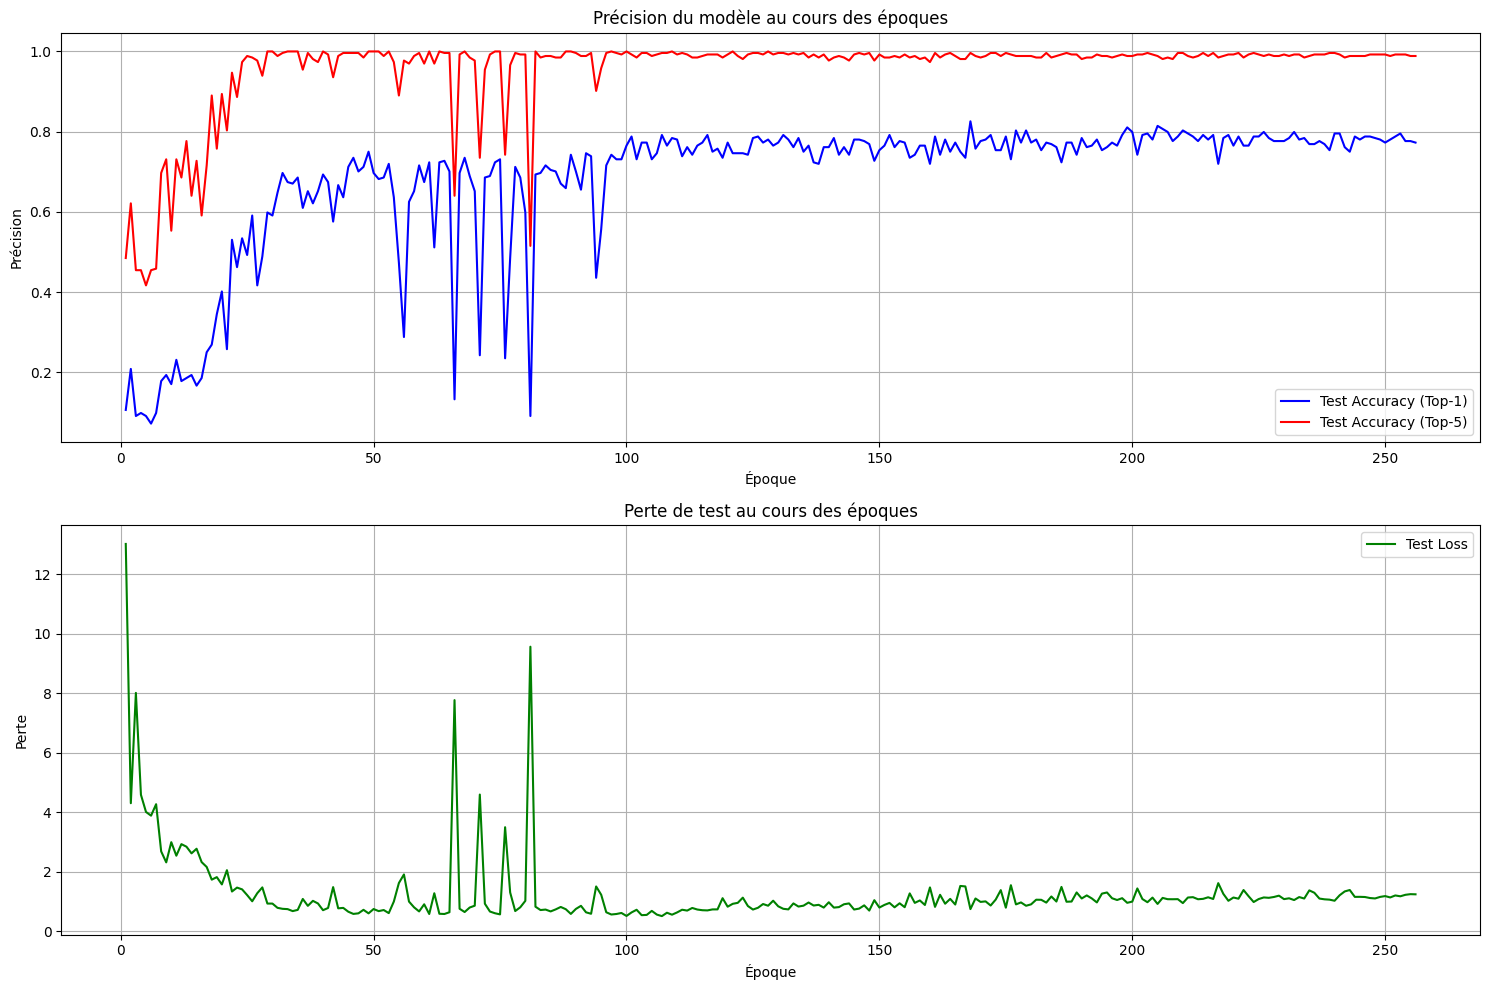

Meilleure précision: 0.8258 à l'époque 168.0


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import glob

def plot_learning_curves(record_path, name_suffix, top_k=5):
    """
    Visualise les courbes d'apprentissage à partir des fichiers .mat générés
    """
    # Recherche du fichier le plus récent
    pattern = os.path.join(record_path, f'Test_*{name_suffix}.mat')
    files = glob.glob(pattern)
    
    if not files:
        print(f"Aucun fichier trouvé avec le pattern: {pattern}")
        return
    
    # Charger le fichier le plus récent
    latest_file = max(files, key=os.path.getctime)
    print(f"Fichier chargé: {latest_file}")
    
    data = loadmat(latest_file)
    record_data = data['Record_data']
    
    # Extraire les données
    epochs = record_data[:, 0]
    test_top1 = record_data[:, 2]
    test_topk = record_data[:, 3]
    test_loss = record_data[:, 4]
    
    # Créer les graphiques
    plt.figure(figsize=(15, 10))
    
    # Précision Top-1 et Top-k
    plt.subplot(2, 1, 1)
    plt.plot(epochs, test_top1, 'b-', label=f'Test Accuracy (Top-1)')
    plt.plot(epochs, test_topk, 'r-', label=f'Test Accuracy (Top-{top_k})')
    plt.title('Précision du modèle au cours des époques')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Perte de test
    plt.subplot(2, 1, 2)
    plt.plot(epochs, test_loss, 'g-', label='Test Loss')
    plt.title('Perte de test au cours des époques')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(record_path, f'learning_curves{name_suffix}.png'))
    plt.show()
    
    return max(test_top1), epochs[np.argmax(test_top1)]

def plot_train_test_comparison(history, top_k=5, save_path=None):
    """
    Compare les métriques d'entraînement et de test
    """
    epochs = history['epochs']
    
    plt.figure(figsize=(15, 15))
    
    # Précision Top-1
    plt.subplot(3, 1, 1)
    plt.plot(epochs, history['train_acc_top1'], 'b-', label='Train Accuracy (Top-1)')
    plt.plot(epochs, history['test_acc_top1'], 'r-', label='Test Accuracy (Top-1)')
    plt.title('Précision Top-1 (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Précision Top-k
    plt.subplot(3, 1, 2)
    plt.plot(epochs, history['train_acc_topk'], 'b-', label=f'Train Accuracy (Top-{top_k})')
    plt.plot(epochs, history['test_acc_topk'], 'r-', label=f'Test Accuracy (Top-{top_k})')
    plt.title(f'Précision Top-{top_k} (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Précision')
    plt.grid(True)
    plt.legend()
    
    # Perte
    plt.subplot(3, 1, 3)
    plt.plot(epochs, history['train_losses'], 'b-', label='Train Loss')
    plt.plot(epochs, history['test_losses'], 'r-', label='Test Loss')
    plt.title('Perte (Train vs Test)')
    plt.xlabel('Époque')
    plt.ylabel('Perte')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

def plot_learning_rate(history, save_path=None):
    """
    Visualise l'évolution du taux d'apprentissage
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history['epochs'], history['learning_rates'], 'b-')
    plt.title("Évolution du taux d'apprentissag")
    plt.xlabel('Époque')
    plt.ylabel("Taux d'apprentissage")
    plt.grid(True)
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

BEGIN_EPOCH = 0
MAX_EPOCH = 50
TOP_K = 5
max_acc, best_epoch = plot_learning_curves(Record_path, Name_suffix, TOP_K)
print(f"Meilleure précision: {max_acc:.4f} à l'époque {best_epoch}")